<h2>Initial audio analysis</h2>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shutil import copyfile
import os

In [3]:
transcripts = pd.read_csv('Alexa_6/Audio and Transcription/Transcriptions-1.csv')

In [4]:
display(transcripts.describe())
display(transcripts.info())

,Timestamp (UTC),Transcription,File,Alexa Response
count,33397,33397,33397,33397
unique,31305,6828,31420,4536
top,Data Not Available,alexa off,92907392a710c140204ce5ac1dd2269c48562a85.wav,Not Applicable
freq,117,4561,7,19346


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33397 entries, 0 to 33396
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Timestamp (UTC)  33397 non-null  object
 1   Transcription    33397 non-null  object
 2   File             33397 non-null  object
 3   Alexa Response   33397 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


None

In [5]:
transcript_time = transcripts[['Timestamp (UTC)']]

In [6]:
display(transcript_time.describe())

,Timestamp (UTC)
count,33397
unique,31305
top,Data Not Available
freq,117


In [7]:
transcript_time = transcript_time[transcript_time['Timestamp (UTC)'] != 'Data Not Available']
display(transcript_time.describe())

,Timestamp (UTC)
count,33280
unique,31304
top,2018-10-21T18:20:47.544Z
freq,7


In [8]:
transcript_time['Timestamp (UTC)'] = pd.to_datetime(transcript_time['Timestamp (UTC)'])

transcript_time['Day of week'] = transcript_time['Timestamp (UTC)'].dt.day_name()

In [9]:
display(transcript_time.head())

,Timestamp (UTC),Day of week
0,2020-06-12 12:04:03.664000+00:00,Friday
1,2020-06-12 12:04:03.664000+00:00,Friday
2,2020-01-05 09:31:19.578000+00:00,Sunday
3,2018-12-12 08:13:19.107000+00:00,Wednesday
4,2019-04-01 06:39:25.197000+00:00,Monday


In [10]:
transcript_time['Time only'] = pd.Series([val.time() for val in transcript_time['Timestamp (UTC)']])

In [11]:
display(transcript_time.head())

,Timestamp (UTC),Day of week,Time only
0,2020-06-12 12:04:03.664000+00:00,Friday,12:04:03.664000
1,2020-06-12 12:04:03.664000+00:00,Friday,12:04:03.664000
2,2020-01-05 09:31:19.578000+00:00,Sunday,09:31:19.578000
3,2018-12-12 08:13:19.107000+00:00,Wednesday,08:13:19.107000
4,2019-04-01 06:39:25.197000+00:00,Monday,06:39:25.197000


In [12]:
all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
all_days_dict = {}
for day in all_days:
    single_day = transcript_time[transcript_time['Day of week'] == day]
    single_day = single_day.groupby(single_day['Timestamp (UTC)'].dt.hour).count()
    single_day[[day]] = single_day[['Day of week']]
    all_days_dict[day] = single_day[[day]]

In [13]:
from functools import reduce
all_days_merged = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True), all_days_dict.values())

<AxesSubplot:xlabel='Timestamp (UTC)'>

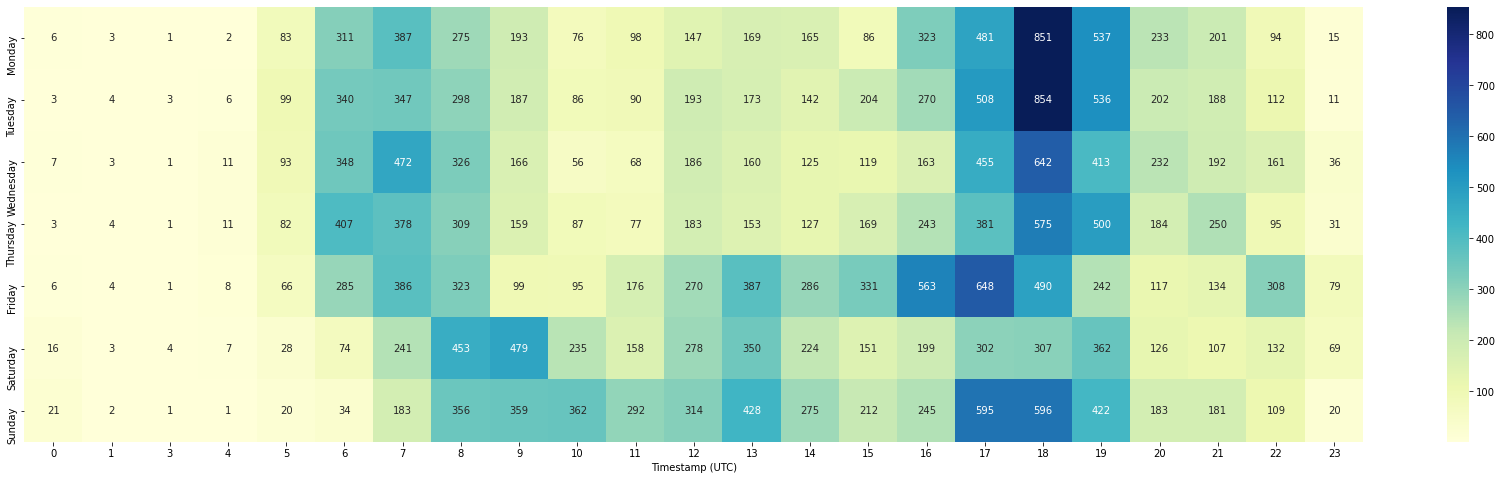

In [14]:
plt.figure(figsize=(30, 8))
sns.heatmap(all_days_merged.transpose(), cmap='YlGnBu', annot=True, fmt="0")

<h2>Specific instances</h2>

In [96]:
swear_words_arr = ['fuck', 'shit', 'bastard']
swear_words_df = pd.DataFrame(columns=['Timestamp (UTC)','Transcription','File','Alexa Response'])

for word in swear_words_arr:
    temp_df = transcripts[transcripts['Transcription'].str.contains(word)]
    swear_words_df = pd.concat([swear_words_df, temp_df])
display(swear_words_df.shape)

(119, 4)

In [16]:
file_names = swear_words_df['File']
potential_prefixes = ['Alexa_6/Audio and Transcription/Audio/', 'Alexa_1/Audio and Transcription/Audio/', 'Audio and Transcription/Audio/','Audio and Transcription-2/Audio/','Audio and Transcription-3/Audio/','Audio and Transcription-4/Audio/']
name = file_names[91]
for idx, name in enumerate(file_names.values):
    for prefix in potential_prefixes:
        path = prefix+name
        if os.path.isfile(path):
            break
    dst = 'CUSTOM/audio'+str(idx+1)+'.wav'
    copyfile(path, dst)

<h2>Speech recognition</h2>

In [42]:
import speech_recognition as sr
import requests
import pydub

In [70]:
r = sr.Recognizer()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="alexa-analysis-ffcc1158ca31.JSON"

In [89]:
segment_list = []
for i in range(1,120):
    path = '/Users/sol/Downloads/Amazon Data/CUSTOM/audio'+str(i)+'.wav'
    with sr.AudioFile(path) as source:
        audio = r.record(source)  # read the entire audio file                  

        res = r.recognize_google_cloud(audio, show_all=True)

    obj = next((x for x in res['results'][0]['alternatives'][0]['words'] if x['word'].lower() in swear_words_arr), None)
    if obj:
        segment = pydub.AudioSegment.from_wav(path)[float(obj['startTime'][:-1])*1000:float(obj['endTime'][:-1])*1000]
        segment_list.append(segment)

In [90]:
fin_seg = pydub.AudioSegment.empty()
for seg in segment_list:
    fin_seg += seg

In [92]:
fin_seg.export('swearing.mp4', format="mp4")

<_io.BufferedRandom name='swearing.mp4'>